# Common Constants

In [1]:
from run_battery import BatteryRunner, BatteryConfigs, sample_cmap, index_axis
from model_wrapper import ModelFamily
import checklist
from checklist.editor import Editor
import matplotlib.pyplot as plt
import os
import numpy as np
import re
import json
import nltk
import scipy

base_config = BatteryConfigs.Bugs2Fix
checklist_config = BatteryConfigs.Bugs2FixChecklist
base_runner = BatteryRunner.of(base_config)
runner = BatteryRunner.of(checklist_config)
runner.load_cases()

Loaded 100 cases!
Loading base config (does not run base config battery)...
Loaded 100 cases!


# Create Mutations

In [2]:
def make_replacements():
    replacements = {}
    method_words = "foo bar baz qux corge grault garply waldo fred thud".split()
    np.random.shuffle(method_words)
    for i, word in enumerate(method_words, start=1):
        replacements[f"METHOD_{i}"] = word

    var_words_1 = "a b c d e f g h i j k l".split()
    var_words_2 = "o p q r s t u v w x y z".split()
    np.random.shuffle(var_words_1)
    np.random.shuffle(var_words_2)
    for i, words in enumerate(zip(var_words_1, var_words_2), start=1):
        replacements[f"VAR_{i}"] = list(words)


    type_words = "Apple Box Cardigan Doohickey Egg Gadget Nicknack Thingy Widget Yak".split()
    np.random.shuffle(type_words)
    for i, word in enumerate(type_words, start=1):
        replacements[f"TYPE_{i}"] = word
    
    # positive or negative geometric distribution, preferring positive numbers
    # this distribution skews towards numbers with smaller absolute values, and towards positive numbers 
    int_count = 5
    per_row = 3
    rivec_size = (int_count, per_row)
    ints = np.random.choice([1, 1, -1], size=rivec_size) * np.random.geometric(0.1, size=rivec_size)
    for i, row in enumerate(ints, start=1):
        replacements[f"INT_{i}"] = [ str(n) for n in row ]
    
    float_count = 4
    rfvec_size = (float_count, per_row)
    floats = np.round(np.clip(np.random.normal(loc=0, scale=150, size=rfvec_size), -1000, 1000), 4)
    for i, row in enumerate(floats, start=1):
        replacements[f"FLOAT_{i}"] = [ str(f) for f in row ]
    

    replacements["CHAR_1"] = "'a' '@' '.'".split()
    replacements["CHAR_2"] = "'b' '&' 'x'".split()
    replacements["CHAR_3"] = "'c' 'L' '_'".split()
    replacements["CHAR_4"] = "'d' '-' 'J'".split()

    replacements["STRING_1"] = ['""', '"truth"']
    replacements["STRING_2"] = ['"results"', '"\\n"']
    replacements["STRING_3"] = ['"Input: "', '"orange"']
    replacements["STRING_4"] = ['"abcdefghijklmnopqrstuvwxyz!.(){}"', '"00000000"']
    replacements["STRING_5"] = ['"unchecked"', '"Courier New"']
    replacements["STRING_6"] = ['"> "', '"EOF"']
    replacements["STRING_7"] = ['"Hello, World!"', '"\\t"']
    replacements["STRING_8"] = ['"\\r\\n"', '"________"']
    replacements["STRING_9"] = ['"asdjiopfapsdfjpoiajdfpoais"', '"9999888666441"']

    # because Checklist selfishly uses numbers at the end of strings internally, we must "escape" ours.
    for key in list(replacements.keys()):
        replacements[f"{key}_OURS"] = replacements[key]
        del replacements[key]

    return replacements

In [3]:
if os.path.exists(runner.battery_path):
    print("Directory already exists, not writing again.")
else:
    battery_path = base_config["battery_path"]
    questions_file_path = os.path.join(battery_path, base_config["questions_file"])
    truth_file_path = os.path.join(battery_path, base_config["truth_file"])

    # if i cared more i could probably write a function for this
    with open(questions_file_path, "r") as qfile:
        questions = [
            line.strip()
            for line
            in qfile.readlines()
        ]
        
        
    with open(truth_file_path, "r") as tfile:
        answers = [
            line.strip()
            for line
            in tfile.readlines()
        ]

    np.random.seed(10)

    # part 2: format the replacements
    format_replacements = re.compile(r"(?:METHOD|VAR|TYPE|INT|CHAR|STRING)_\d+")
    editor = Editor()
    new_files = {
        "questions": [],
        "answers": [],
        "extras": [],
    }
    for i, pair in enumerate(zip(questions, answers), start=1):
        print(f"{i = } / {len(questions)}...", end="\r")
        replacements = make_replacements()
        # we join to make sure the same modifications are made to each question/answer pair
        joined = "\n".join(pair)
        
        # escape { and }, which are special to Editor, for the checklist replacement
        formatted = joined.replace("{", "B2F_OPEN_CURLY_BRACKET").replace("}", "B2F_CLOSE_CURLY_BRACKET")
        formatted = re.sub(format_replacements, r"{\g<0>_OURS}", formatted)

        template_options = editor.template(formatted, **replacements)
        templated = np.random.choice(template_options.data)
        
        # unescape { and }
        templated = templated.replace("B2F_OPEN_CURLY_BRACKET", "{").replace("B2F_CLOSE_CURLY_BRACKET", "}")

        q, a = templated.split("\n")
        new_files["questions"].append(q)
        new_files["answers"].append(a)
        # record extra information for use in data analysis
        levenshtein_distance = nltk.edit_distance(pair[0], q)
        new_files["extras"].append({
            "lev": levenshtein_distance
        })
    print()
    
    print("Average lev dist:", sum(n["lev"] for n in new_files["extras"]) / len(new_files["extras"]))
    
    # part 3: save the files
    os.makedirs(runner.battery_path, exist_ok=True)
    extra_info_path = os.path.join(runner.battery_path, "extras.json")
    with open(extra_info_path, "w+", encoding="utf-8") as efile:
        efile.write(json.dumps(new_files["extras"]) + "\n")
    with open(runner.questions_path, "w+", encoding="utf-8") as qfile:
        qfile.write("\n".join(new_files["questions"]) + "\n")
    with open(runner.truth_path, "w+", encoding="utf-8") as tfile:
        tfile.write("\n".join(new_files["answers"]) + "\n")
    print("Saved files.")

Directory already exists, not writing again.


In [4]:
runner.load_cases()

Loaded 100 cases!


In [5]:
from model_wrapper import ModelFamily

# Generate Output

In [2]:
runner.run_battery(
    family=ModelFamily.CodeGen1.multi,
    # patch=False,
    patch=True,
)

HTML(value="<h1 style='font-weight: bold; border-bottom: 1px solid;'>Testing prompt index 0</h1>")

# Testing prompt index 0
Prompt to be tested:
// the buggy version of the code
{prompt}
// the fixed version of the code



HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 350M (Salesforce/codegen-350M-mu…

## Loading 350M (Salesforce/codegen-350M-multi)
Opening ./output/bugs2fix_checklist/prompt0/codegen1-multi-350M.output...
Preparing file for patching...


Regenerating empty test case index 14 for 'public void grault ( Nicknack o ) { super . grault ( o ) ; e . garply ( o ) ; q . qux ( o ) ; z . bar ( o ) ; w . bar ( o ) ; fred ( o ) ; }' with prompt '// the buggy version of the code\npublic void grault ( Nicknack o ) { super . grault ( o ) ; e . garply ( o ) ; q . qux ( o ) ; z . bar ( o ) ; w . bar ( o ) ; fred ( o ) ; }\n// the fixed version of the code\n'...
[2024-06-25@21:13:35|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-06-25@21:13:35|model.device] Time elapsed: 46ms
[2024-06-25@21:13:35|model.tokenizer] Starting timer.
[2024-06-25@21:13:35|model.tokenizer] Time elapsed: 233ms
[2024-06-25@21:13:35|model.model] Starting timer.
Obtaining model...
[2024-06-25@21:13:39|model.model] Time elapsed: 3s 355ms
Patched output: 'public void grault ( Nicknack o, int i ) { super. grault ( o, i ) ; e. garply ( o, i ) ; q. qux ( o, i ) ; z. bar ( o, i ) ; w. bar ( o, i ) ; fred ( o, i ) ; }'
Regen

HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 2B (Salesforce/codegen-2B-multi)…

## Loading 2B (Salesforce/codegen-2B-multi)
Opening ./output/bugs2fix_checklist/prompt0/codegen1-multi-2B.output...
Preparing file for patching...


Done, 41ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 6B (Salesforce/codegen-6B-multi)…

## Loading 6B (Salesforce/codegen-6B-multi)
Opening ./output/bugs2fix_checklist/prompt0/codegen1-multi-6B.output...
Preparing file for patching...


Done, 39ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 16B (Salesforce/codegen-16B-mult…

## Loading 16B (Salesforce/codegen-16B-multi)
Opening ./output/bugs2fix_checklist/prompt0/codegen1-multi-16B.output...
Preparing file for patching...


Done, 39ms elapsed.


HTML(value="<h1 style='font-weight: bold; border-bottom: 1px solid;'>Testing prompt index 1</h1>")

# Testing prompt index 1
Prompt to be tested:
// You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
{prompt}



HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 350M (Salesforce/codegen-350M-mu…

## Loading 350M (Salesforce/codegen-350M-multi)
Opening ./output/bugs2fix_checklist/prompt1/codegen1-multi-350M.output...
Preparing file for patching...


Done, 49ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 2B (Salesforce/codegen-2B-multi)…

## Loading 2B (Salesforce/codegen-2B-multi)
Opening ./output/bugs2fix_checklist/prompt1/codegen1-multi-2B.output...
Preparing file for patching...


Done, 38ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 6B (Salesforce/codegen-6B-multi)…

## Loading 6B (Salesforce/codegen-6B-multi)
Opening ./output/bugs2fix_checklist/prompt1/codegen1-multi-6B.output...
Preparing file for patching...


Done, 38ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 16B (Salesforce/codegen-16B-mult…

## Loading 16B (Salesforce/codegen-16B-multi)
Opening ./output/bugs2fix_checklist/prompt1/codegen1-multi-16B.output...
Preparing file for patching...


Done, 40ms elapsed.


HTML(value="<h1 style='font-weight: bold; border-bottom: 1px solid;'>Testing prompt index 2</h1>")

# Testing prompt index 2
Prompt to be tested:
// You are given a piece of buggy code. Your task is to fix the error, and generate the corrected code. Fix the following code:
{prompt}
// The following code is correct:



HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 350M (Salesforce/codegen-350M-mu…

## Loading 350M (Salesforce/codegen-350M-multi)
Opening ./output/bugs2fix_checklist/prompt2/codegen1-multi-350M.output...
Preparing file for patching...


Done, 48ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 2B (Salesforce/codegen-2B-multi)…

## Loading 2B (Salesforce/codegen-2B-multi)
Opening ./output/bugs2fix_checklist/prompt2/codegen1-multi-2B.output...
Preparing file for patching...


Done, 54ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 6B (Salesforce/codegen-6B-multi)…

## Loading 6B (Salesforce/codegen-6B-multi)
Opening ./output/bugs2fix_checklist/prompt2/codegen1-multi-6B.output...
Preparing file for patching...


Done, 38ms elapsed.


HTML(value="<h2 style='font-weight: bold; border-bottom: 1px dotted;'>Loading 16B (Salesforce/codegen-16B-mult…

## Loading 16B (Salesforce/codegen-16B-multi)
Opening ./output/bugs2fix_checklist/prompt2/codegen1-multi-16B.output...
Preparing file for patching...


Done, 41ms elapsed.


# Interpret Output

In [2]:
import metric
runner.init_render(family=ModelFamily.CodeGen1.multi)

Saved figure to ./figs/b2f-cl-all.png


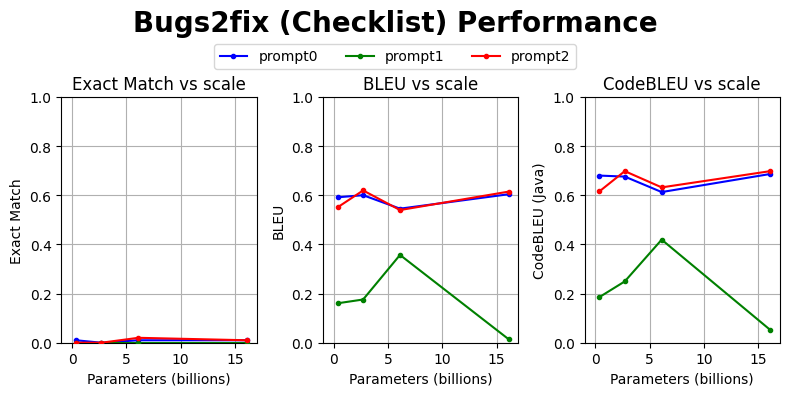

[{'prompt0': [0.01, 0.0, 0.01, 0.01],
  'prompt1': [0.0, 0.0, 0.0, 0.0],
  'prompt2': [0.0, 0.0, 0.02, 0.01]},
 {'prompt0': [0.5918350248483545,
   0.600406931103176,
   0.5455959474120977,
   0.6042161527054498],
  'prompt1': [0.16049203357506017,
   0.17587034302500942,
   0.3572169986101516,
   0.014455677189210047],
  'prompt2': [0.5509405997488187,
   0.6197289251181732,
   0.5398913802834645,
   0.6149254940943188]},
 {'prompt0': [0.6802196789348955,
   0.6760881033633952,
   0.6131400256475396,
   0.6867325572543022],
  'prompt1': [0.18533060752934005,
   0.2495334791813979,
   0.4194327258702645,
   0.052124209943583],
  'prompt2': [0.6154307107316426,
   0.6982974611278845,
   0.6321488085639098,
   0.6982595332477076]}]

In [3]:
runner.render_metric_multi(
    [ metric.ExactMatch, metric.BLEU, metric.CodeBLEUJava ],
    save="./figs/b2f-cl-all.png",
)

## Individual graphs

Saved figure to ./figs/b2f-cl-1.png


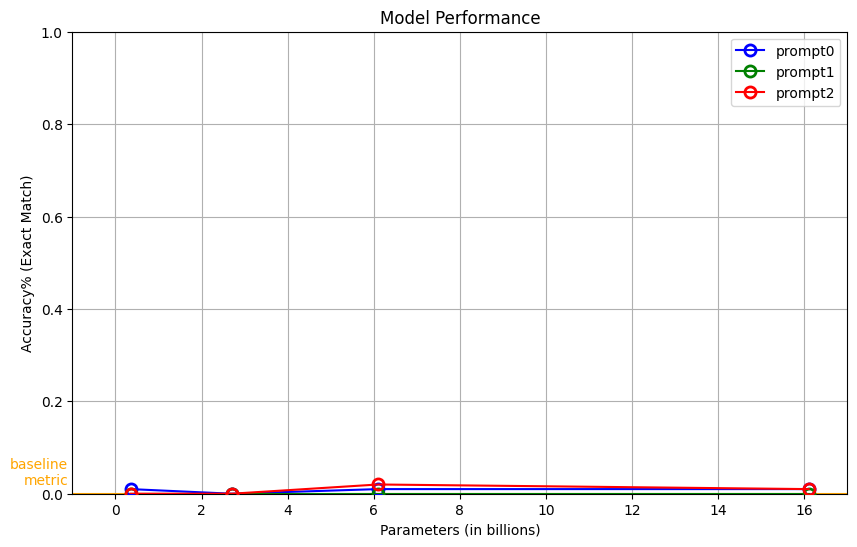

Saved figure to ./figs/b2f-cl-2.png


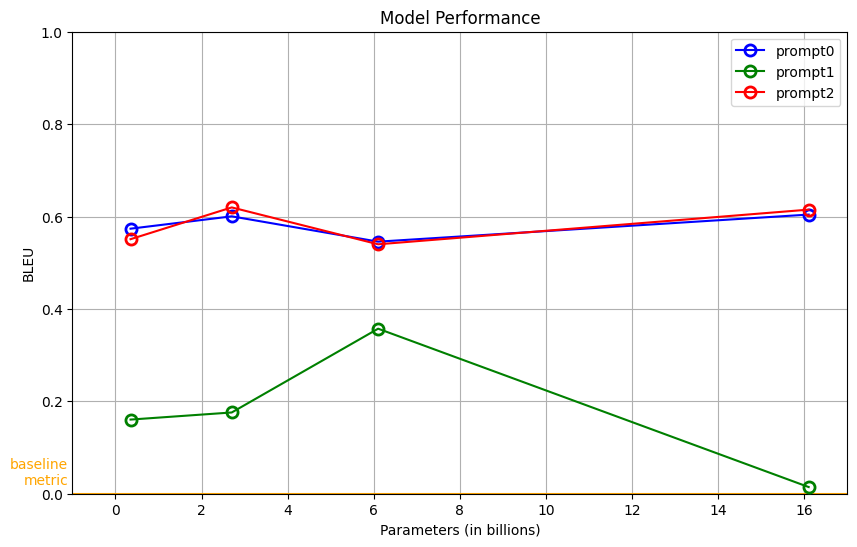

Saved figure to ./figs/b2f-cl-3.png


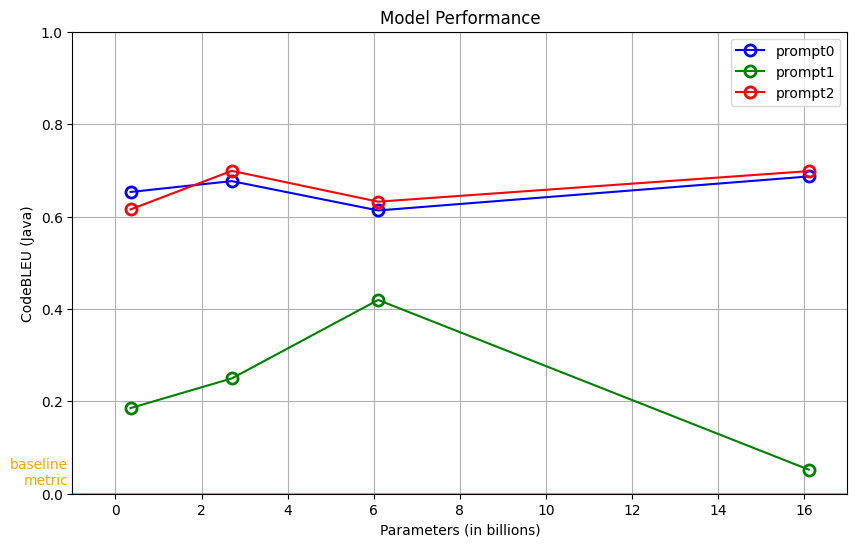

{'prompt0': [0.6531550591670596,
  0.6766499011162042,
  0.6131400256475396,
  0.6867325572543022],
 'prompt1': [0.18533060752934005,
  0.2495334791813979,
  0.4194327258702645,
  0.052124209943583],
 'prompt2': [0.6154307107316426,
  0.6988592588806936,
  0.6321488085639098,
  0.6982595332477076]}

In [4]:
runner.render_metric(metric.ExactMatch, save="./figs/b2f-cl-1.png")
runner.render_metric(metric.BLEU, save="./figs/b2f-cl-2.png")
runner.render_metric(metric.CodeBLEUJava, save="./figs/b2f-cl-3.png")

# Relationship between edit distance and accuracy

BLEU & prompt0 & 350M & 0.00080 & 0.49791 & 0.00080 & 0.10125 \\
BLEU & prompt0 & 2B & 0.00069 & 0.51346 & 0.00070 & 0.09845 \\
BLEU & prompt0 & 6B & -0.00092 & 0.55620 & 0.00082 & -0.11246 \\
BLEU & prompt0 & 16B & 0.00055 & 0.51551 & 0.00082 & 0.06771 \\


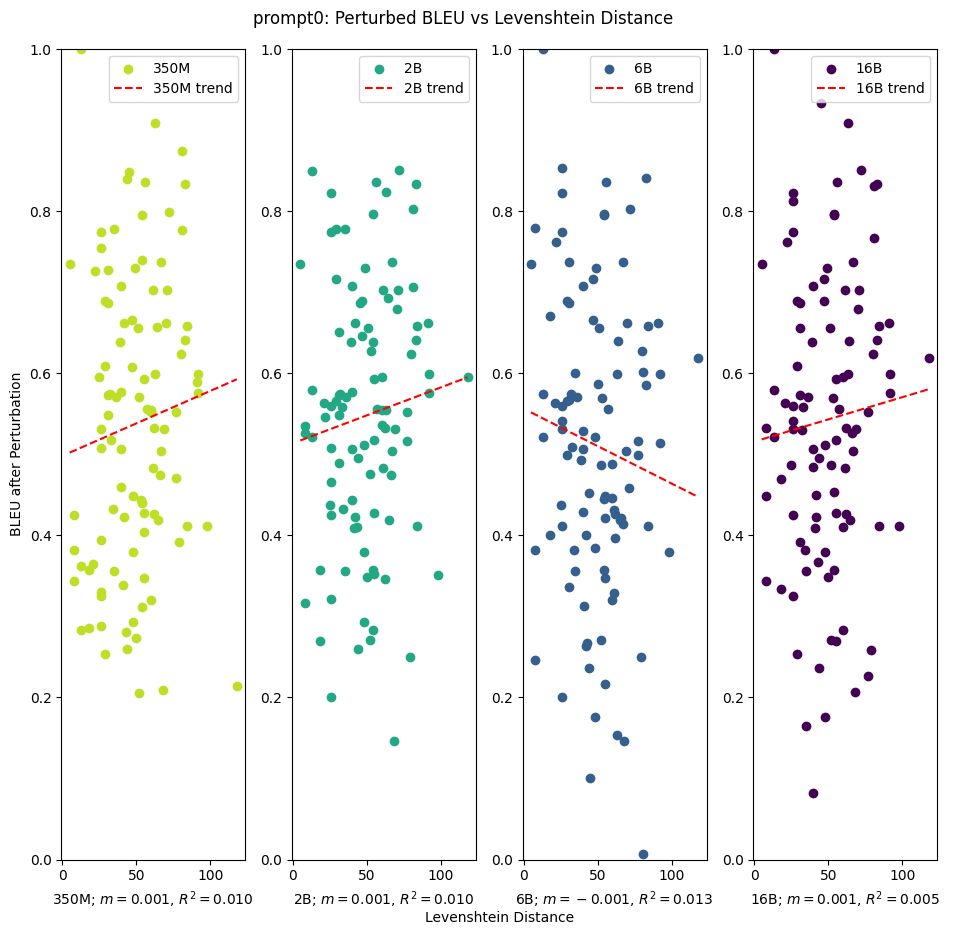

BLEU & prompt1 & 350M & 0.00067 & 0.12265 & 0.00103 & 0.06550 \\
BLEU & prompt1 & 2B & -0.00062 & 0.24596 & 0.00107 & -0.05875 \\
BLEU & prompt1 & 6B & -0.00090 & 0.38145 & 0.00113 & -0.08056 \\
BLEU & prompt1 & 16B & -0.00184 & 0.15027 & 0.00054 & -0.32411 \\


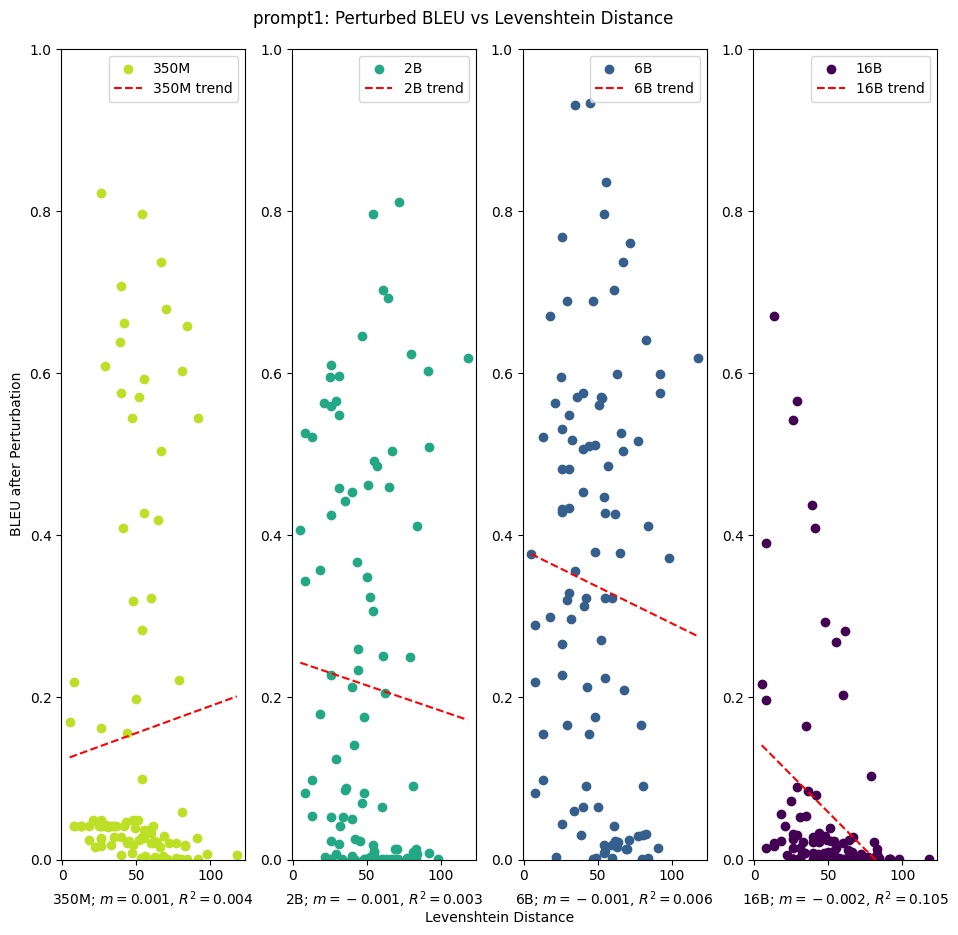

BLEU & prompt2 & 350M & -0.00004 & 0.49679 & 0.00098 & -0.00392 \\
BLEU & prompt2 & 2B & -0.00012 & 0.57173 & 0.00075 & -0.01571 \\
BLEU & prompt2 & 6B & -0.00032 & 0.53796 & 0.00078 & -0.04083 \\
BLEU & prompt2 & 16B & 0.00020 & 0.54963 & 0.00075 & 0.02707 \\


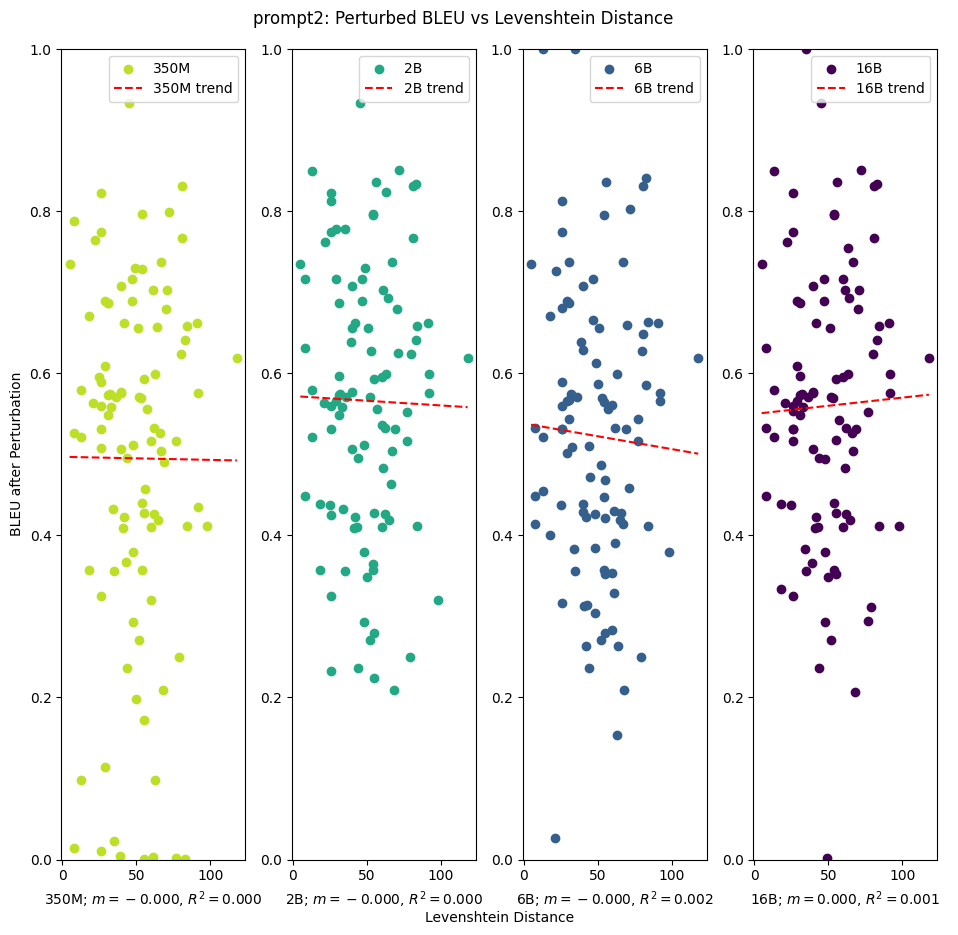

In [3]:
test_metric = metric.BLEU
for idx, family_answers in enumerate(runner.prompt_family_answers):
    series_name = f"prompt{idx}"
    runner.render_perturbations(
        test_metric,
        series_name=series_name,
        save=f"figs/b2f-cl-pert-bleu-p{idx}.png"
    )

/usr/local/lib/python3.8/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


CodeBLEU & prompt0 & 350M & 0.00106 & 0.62378 & 0.00065 & 0.16303 \\
CodeBLEU & prompt0 & 2B & 0.00126 & 0.62228 & 0.00059 & 0.21045 \\
CodeBLEU & prompt0 & 6B & -0.00002 & 0.64393 & 0.00070 & -0.00292 \\
CodeBLEU & prompt0 & 16B & 0.00116 & 0.62598 & 0.00068 & 0.16907 \\


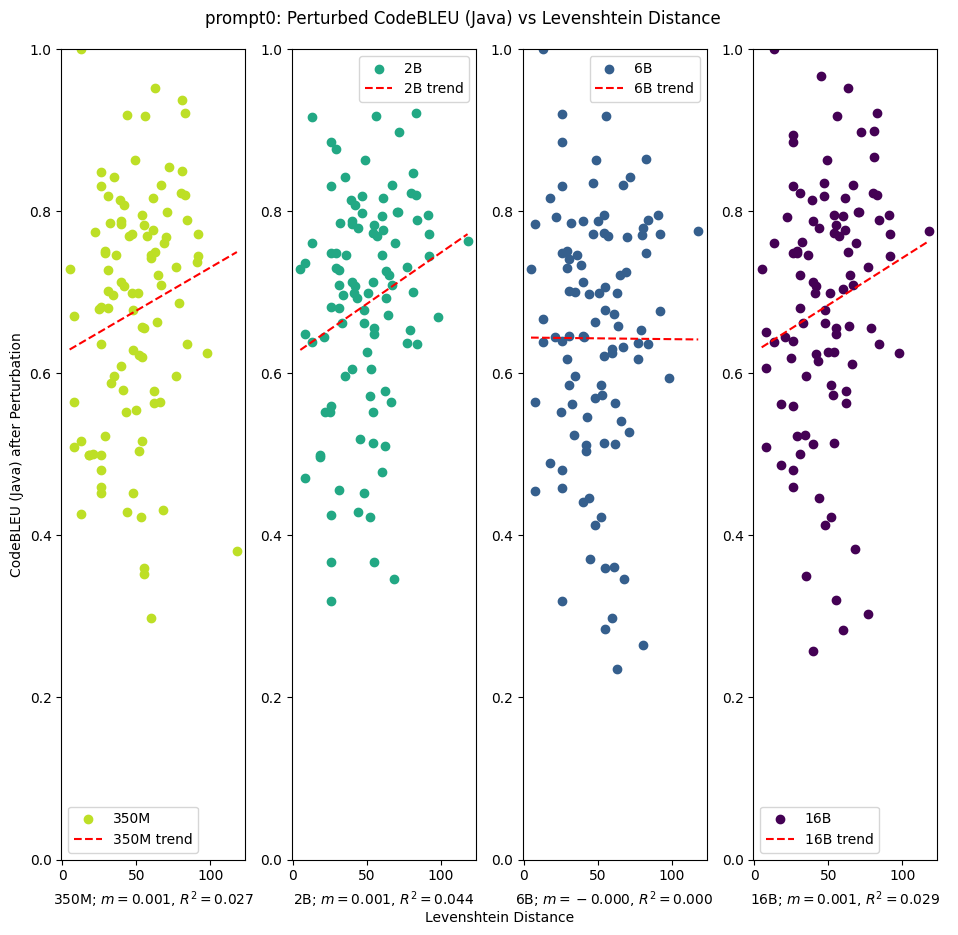

CodeBLEU & prompt1 & 350M & 0.00107 & 0.31646 & 0.00087 & 0.12308 \\
CodeBLEU & prompt1 & 2B & 0.00004 & 0.42549 & 0.00087 & 0.00406 \\
CodeBLEU & prompt1 & 6B & -0.00009 & 0.52111 & 0.00094 & -0.00920 \\
CodeBLEU & prompt1 & 16B & -0.00129 & 0.34970 & 0.00049 & -0.25781 \\


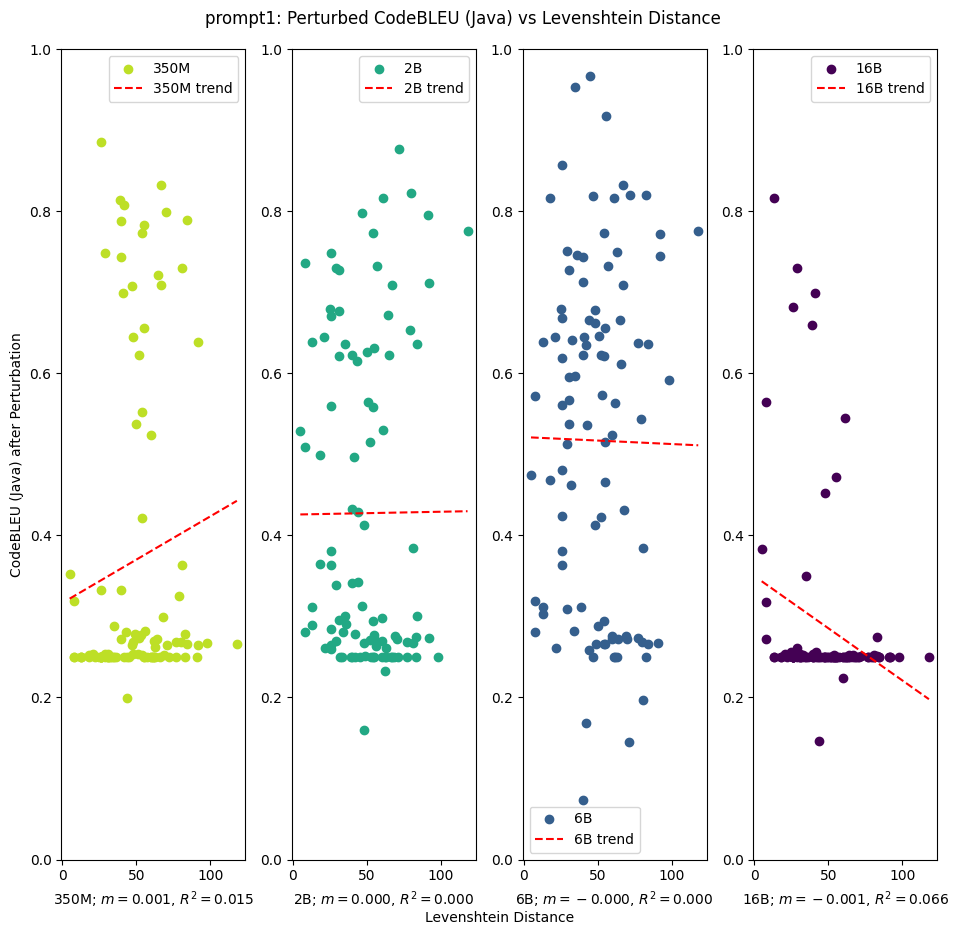

CodeBLEU & prompt2 & 350M & 0.00064 & 0.61134 & 0.00079 & 0.08147 \\
CodeBLEU & prompt2 & 2B & 0.00059 & 0.67535 & 0.00059 & 0.10052 \\
CodeBLEU & prompt2 & 6B & 0.00034 & 0.63925 & 0.00066 & 0.05257 \\
CodeBLEU & prompt2 & 16B & 0.00084 & 0.65618 & 0.00059 & 0.14229 \\


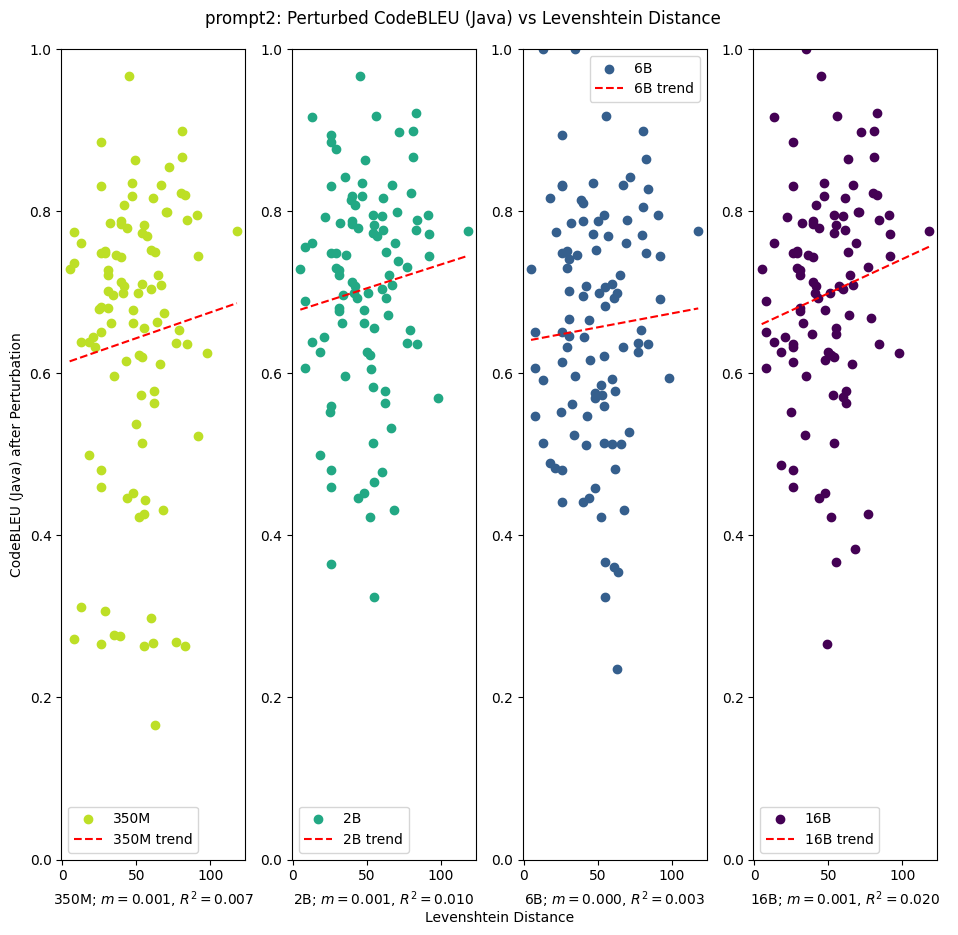

In [4]:
test_metric = metric.CodeBLEUJava
for idx, family_answers in enumerate(runner.prompt_family_answers):
    series_name = f"prompt{idx}"
    runner.render_perturbations(
        test_metric,
        series_name=series_name,
        save=f"figs/b2f-cl-pert-codebleu-p{idx}.png"
    )

# Differences from baseline

BLEU & prompt0 & 350M & 0.00289 & 0.11581 & 0.00066 & 0.40513 \\
BLEU & prompt0 & 2B & 0.00332 & 0.09547 & 0.00062 & 0.47775 \\
BLEU & prompt0 & 6B & 0.00071 & 0.21571 & 0.00090 & 0.07892 \\
BLEU & prompt0 & 16B & 0.00258 & 0.14091 & 0.00070 & 0.34689 \\
BLEU & prompt1 & 350M & 0.00264 & -0.09425 & 0.00103 & 0.25031 \\
BLEU & prompt1 & 2B & 0.00219 & -0.03233 & 0.00116 & 0.18676 \\
BLEU & prompt1 & 6B & 0.00180 & 0.07927 & 0.00114 & 0.15795 \\
BLEU & prompt1 & 16B & 0.00135 & -0.15816 & 0.00077 & 0.17407 \\
BLEU & prompt2 & 350M & 0.00207 & 0.12434 & 0.00098 & 0.20815 \\
BLEU & prompt2 & 2B & 0.00180 & 0.18934 & 0.00059 & 0.29702 \\
BLEU & prompt2 & 6B & 0.00169 & 0.18680 & 0.00086 & 0.19569 \\
BLEU & prompt2 & 16B & 0.00272 & 0.13498 & 0.00063 & 0.39901 \\


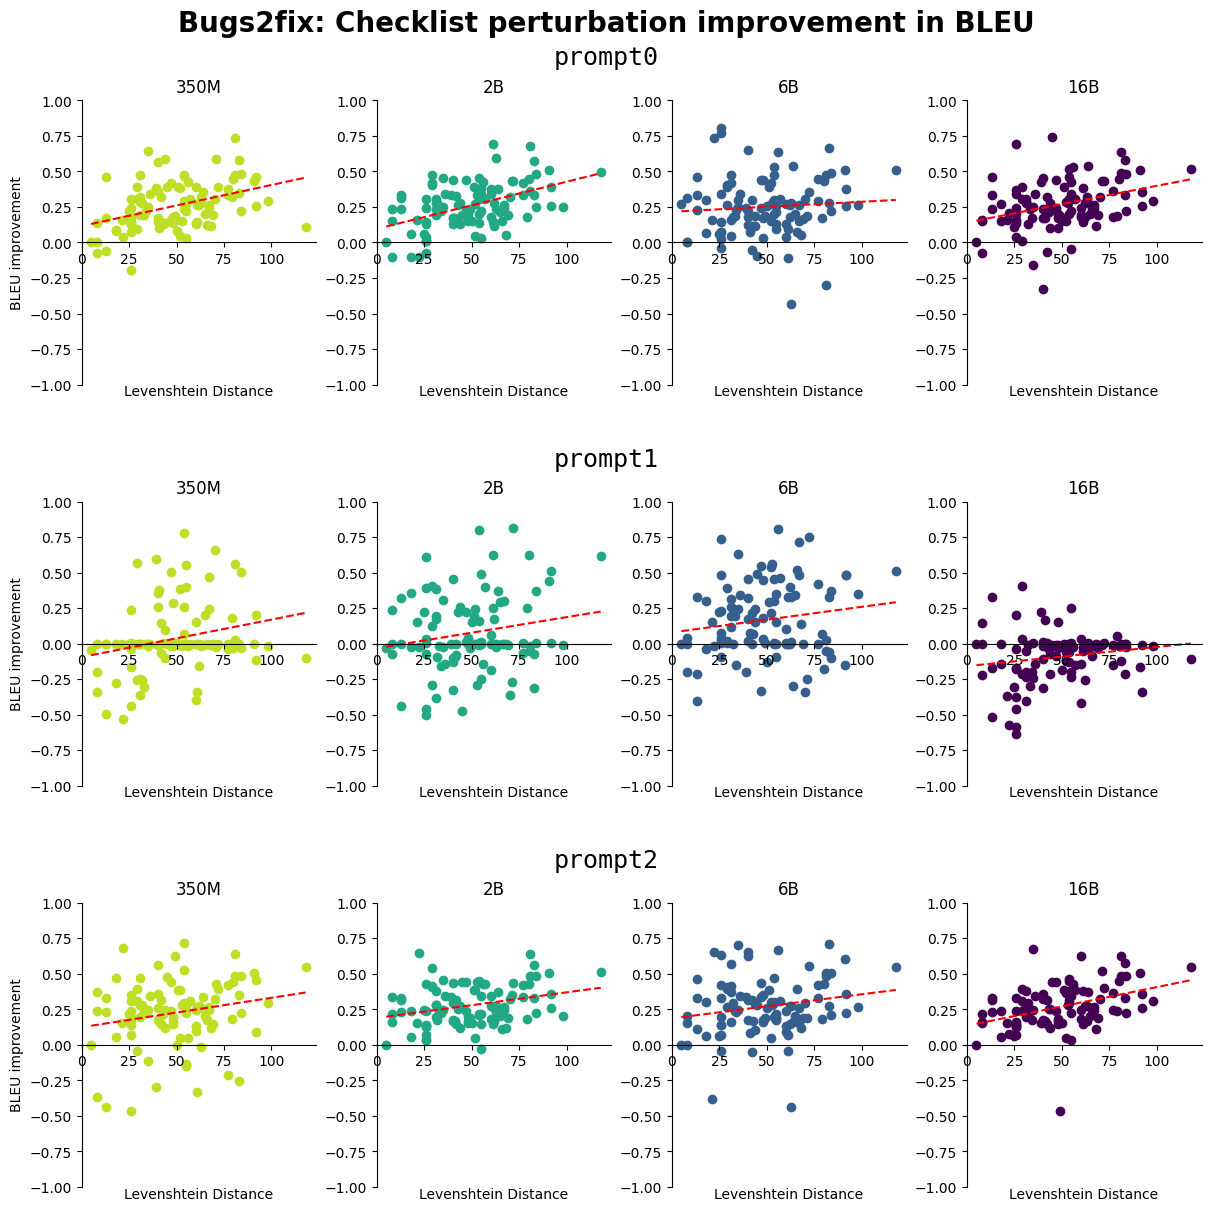

In [2]:
import metric
runner.init_render(family=ModelFamily.CodeGen1.multi)

test_metric = metric.BLEU
runner.render_all_perturbations_relative(
    test_metric,
    title=f"Bugs2fix: Checklist perturbation improvement in {test_metric.simplename}",
    save="figs/b2f-cl-pert-rel-bleu-all.png"
)

/usr/local/lib/python3.8/dist-packages/tree_sitter/__init__.py:36: FutureWarning: Language(path, name) is deprecated. Use Language(ptr, name) instead.
  warn("{} is deprecated. Use {} instead.".format(old, new), FutureWarning)


CodeBLEU & prompt0 & 350M & 0.00177 & 0.08638 & 0.00064 & 0.26903 \\
CodeBLEU & prompt0 & 2B & 0.00239 & 0.04619 & 0.00057 & 0.39109 \\
CodeBLEU & prompt0 & 6B & 0.00033 & 0.14781 & 0.00081 & 0.04055 \\
CodeBLEU & prompt0 & 16B & 0.00154 & 0.10189 & 0.00061 & 0.24479 \\
CodeBLEU & prompt1 & 350M & 0.00236 & -0.08397 & 0.00094 & 0.24563 \\
CodeBLEU & prompt1 & 2B & 0.00235 & -0.04683 & 0.00096 & 0.24141 \\
CodeBLEU & prompt1 & 6B & 0.00190 & 0.02246 & 0.00099 & 0.19031 \\
CodeBLEU & prompt1 & 16B & 0.00107 & -0.11863 & 0.00078 & 0.13728 \\
CodeBLEU & prompt2 & 350M & 0.00122 & 0.08830 & 0.00088 & 0.13878 \\
CodeBLEU & prompt2 & 2B & 0.00098 & 0.13222 & 0.00048 & 0.20207 \\
CodeBLEU & prompt2 & 6B & 0.00094 & 0.13970 & 0.00074 & 0.12625 \\
CodeBLEU & prompt2 & 16B & 0.00185 & 0.08879 & 0.00050 & 0.34744 \\


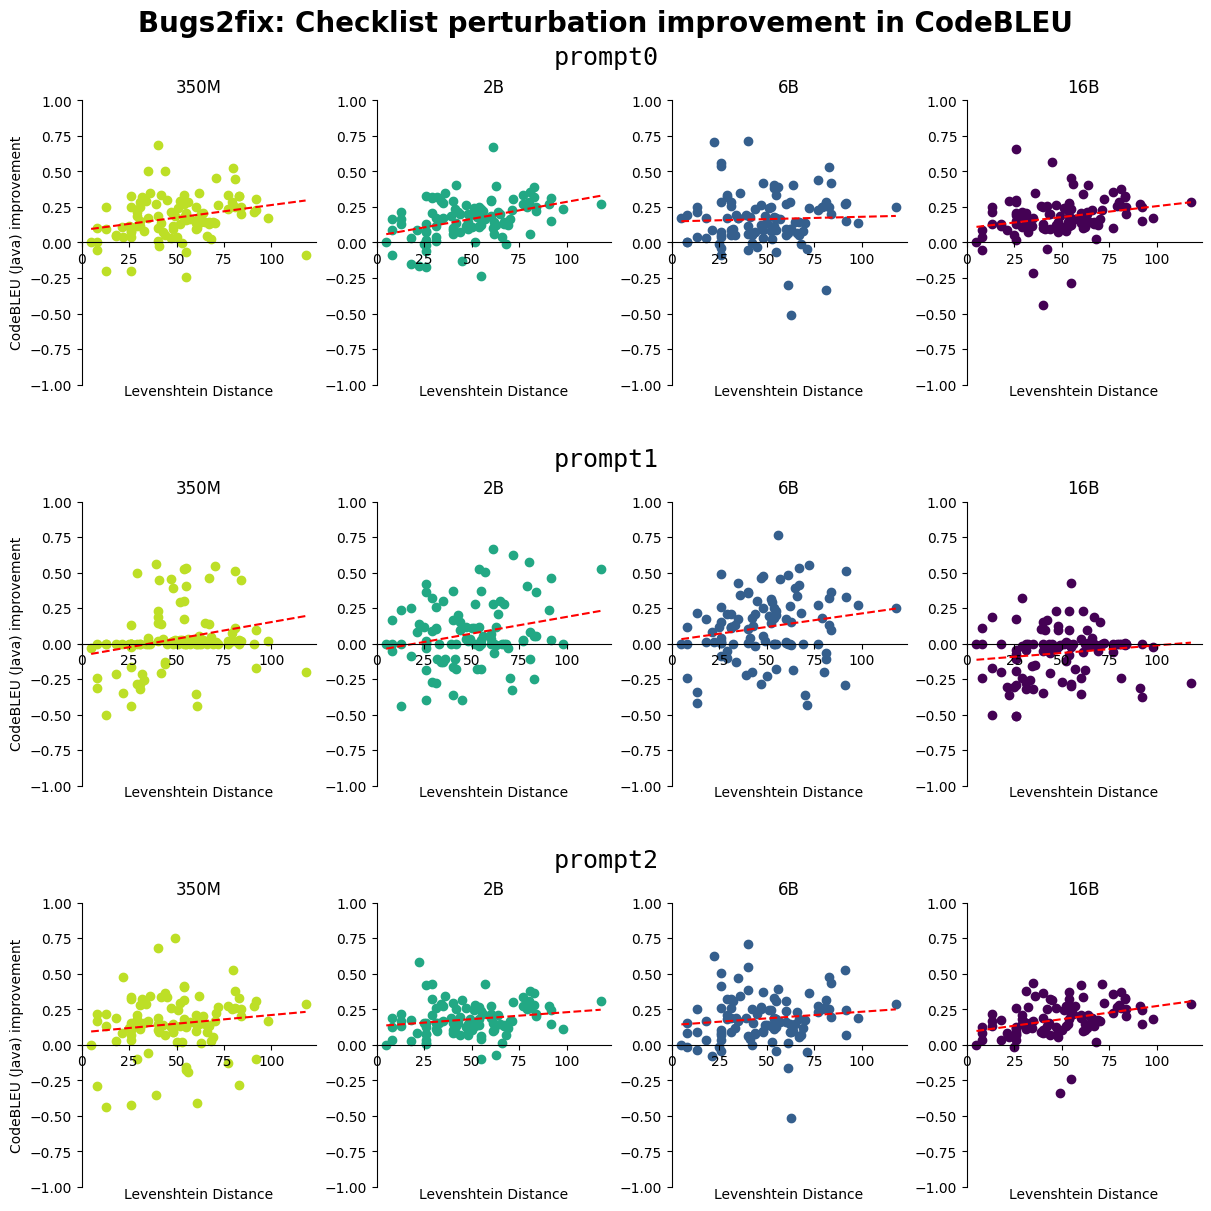

In [3]:
test_metric = metric.CodeBLEUJava
runner.render_all_perturbations_relative(
    test_metric,
    title=f"Bugs2fix: Checklist perturbation improvement in {test_metric.simplename}",
    save="figs/b2f-cl-pert-rel-codebleu-all.png"
)